<a href="https://colab.research.google.com/github/phycoding/LGMVIP-DataScience/blob/main/LGM_next_word_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [2]:
text = open('/content/drive/MyDrive/Datasets_LGM/1661-0.txt').read().lower()

In [3]:
len(text)

581888

In [4]:
text

'\ufeff\nproject gutenberg\'s the adventures of sherlock holmes, by arthur conan doyle\n\nthis ebook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  you may copy it, give it away or\nre-use it under the terms of the project gutenberg license included\nwith this ebook or online at www.gutenberg.net\n\n\ntitle: the adventures of sherlock holmes\n\nauthor: arthur conan doyle\n\nrelease date: november 29, 2002 [ebook #1661]\nlast updated: may 20, 2019\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\n*** start of this project gutenberg ebook the adventures of sherlock holmes ***\n\n\n\nproduced by an anonymous project gutenberg volunteer and jose menendez\n\n\n\ncover\n\n\n\nthe adventures of sherlock holmes\n\n\n\nby arthur conan doyle\n\n\n\ncontents\n\n\n   i.     a scandal in bohemia\n   ii.    the red-headed league\n   iii.   a case of identity\n   iv.    the boscombe valley mystery\n   v.     the five orange pips\n   vi.    the man wi

In [5]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

In [6]:
tokenizer.texts_to_sequences(['oh my god'])

[[5, 8, 1, 15, 18, 1, 20, 5, 11]]

In [7]:
tokenizer.sequences_to_texts([[5, 8, 1, 15, 18, 1, 20, 5, 11]])

['o h   m y   g o d']

In [8]:
tokenizer.document_count
maxid = len(tokenizer.word_index)

In [9]:
[encoded] = np.array(tokenizer.texts_to_sequences([text]))-1
train_size = tokenizer.document_count *90//100
Dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [10]:
n_step = 100
window_length = n_step+1
dataset = Dataset.window(window_length,shift=1,drop_remainder=True)

In [11]:
dataset = dataset.flat_map(lambda window:window.batch(window_length))

In [12]:
batch_size = 32
dataset = dataset.shuffle(1000).batch(32)
dataset = dataset.map(lambda windows: (windows[:,:-1],windows[:,1:]))
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=maxid), Y_batch))

In [13]:
dataset= dataset.prefetch(1)

In [14]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 73) (32, 100)


In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, maxid],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(maxid,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
16363/16363 [==============================] - 233s 13ms/step - loss: 1.8530
Epoch 2/10
16363/16363 [==============================] - 211s 13ms/step - loss: 1.6071
Epoch 3/10
16363/16363 [==============================] - 212s 13ms/step - loss: 1.5698
Epoch 4/10
16363/16363 [==============================] - 212s 13ms/step - loss: 1.5503
Epoch 5/10
16363/16363 [==============================] - 213s 13ms/step - loss: 1.5389
Epoch 6/10
16363/16363 [==============================] - 214s 13ms/step - loss: 1.5298
Epoch 7/10
16363/16363 [==============================] - 215s 13ms/step - loss: 1.5219
Epoch 8/10
16363/16363 [==============================] - 216s 13ms/step - loss: 1.5139
Epoch 9/10
16363/16363 [==============================] - 208s 13ms/step - loss: 1.5096
Epoch 10/10
16363/16363 [==============================] - 208s 13ms/step - loss: 1.5055


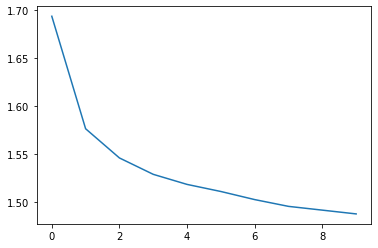

In [ ]:
import pandas as pd
plt.plot(pd.DataFrame(history.history))

In [17]:
model.save('my_model.h5')
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('/content/drive/MyDrive/Datasets_LGM/My_models_rnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets_LGM/My_models_rnn/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets_LGM/My_models_rnn/assets


In [15]:
model = keras.models.load_model('/content/drive/MyDrive/Datasets_LGM/My_models_rnn')

In [ ]:
def preprocess(text):
  X = np.array(tokenizer.texts_to_sequences(text))-1
  return tf.one_hot(X,maxid)

In [ ]:
X_new = preprocess(["I am going "])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

't'

Full text prediction upto 20 characters. within a function it will predict character by character.

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0] 

In [ ]:
def complete_text(text, n_chars=10, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
tf.random.set_seed(42)

In [ ]:
print(complete_text('You are a',temperature=0.2))

You are a man without a very few minutes of the matter. i h
